In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 



2023-11-13 12:23:59.528157: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 12:23:59.940216: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 12:23:59.940237: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 12:23:59.942683: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 12:24:00.169871: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 12:24:00.171990: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

  Emotions                                               Path
0      sad  dataset/Ravdess/audio_speech_actors_01-24/Acto...
1    angry  dataset/Ravdess/audio_speech_actors_01-24/Acto...
2     fear  dataset/Ravdess/audio_speech_actors_01-24/Acto...
3    happy  dataset/Ravdess/audio_speech_actors_01-24/Acto...
4    angry  dataset/Ravdess/audio_speech_actors_01-24/Acto...


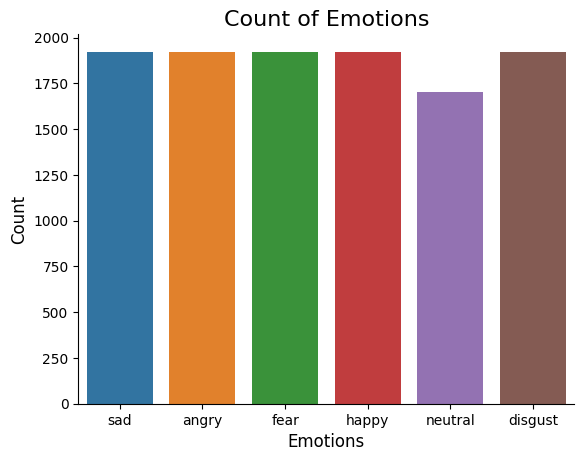

In [2]:
readWavs = False

if not readWavs:
    data_path = pd.read_csv('data_path.csv')
    print(data_path.head())

if readWavs:
    Ravdess = "dataset/Ravdess/audio_speech_actors_01-24/"
    Crema = "dataset/Crema/"
    Tess = "dataset/Tess/"
    Savee = "dataset/Savee/"
    ravdess_directory_list = os.listdir(Ravdess)

    file_emotion = []
    file_path = []
    for dir in ravdess_directory_list:

        # As their are 20 different actors in our previous directory we need to extract files for each actor.
        actor = os.listdir(Ravdess + dir)
        for file in actor:

            part = file.split('.')[0]
            part = part.split('-')

            # Third part in each file represents the emotion associated to that file.
            if int(part[2]) == 2 or int(part[2]) == 8: continue

            # Remove suprise and calm datasets due to insufficient sample data
            file_emotion.append(int(part[2]))
            file_path.append(Ravdess + dir + '/' + file)
            
    # Dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # Dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

    # Changing integers to actual emotions.
    Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
    Ravdess_df.head()


    # Processing the audio files-----------------------------------------------------------------------------


    # Crema Processing
    crema_directory_list = os.listdir(Crema)

    file_emotion = []
    file_path = []

    for file in crema_directory_list:

        # storing file paths
        file_path.append(Crema + file)

        # storing file emotions
        part=file.split('_')
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
            
    # Dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # Dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Crema_df = pd.concat([emotion_df, path_df], axis=1)
    Crema_df.head()

    #Tess processing
    tess_directory_list = os.listdir(Tess)

    file_emotion = []
    file_path = []

    for dir in tess_directory_list:
        directories = os.listdir(Tess + dir)
        for file in directories:
            part = file.split('.')[0]
            part = part.split('_')[2]
            if part=='ps':
                continue
            else:
                file_emotion.append(part)
            file_path.append(Tess + dir + '/' + file)
            
    # Dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # Dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Tess_df = pd.concat([emotion_df, path_df], axis=1)
    Tess_df.head()

    # Savee processing
    savee_directory_list = os.listdir(Savee)

    file_emotion = []
    file_path = []

    for file in savee_directory_list:
        file_path.append(Savee + file)
        part = file.split('_')[1]
        ele = part[:-6]
        if ele=='a':
            file_emotion.append('angry')
        elif ele=='d':
            file_emotion.append('disgust')
        elif ele=='f':
            file_emotion.append('fear')
        elif ele=='h':
            file_emotion.append('happy')
        elif ele=='n':
            file_emotion.append('neutral')
        elif ele=='sa':
            file_emotion.append('sad')
        #else:
            #file_emotion.append('surprise')
            
    # Dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # Dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Savee_df = pd.concat([emotion_df, path_df], axis=1)
    Savee_df.head()

    # To csv
    data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
    data_path.to_csv("data_path.csv",index=False)
    data_path.head()

plt.title('Count of Emotions', size=16)
sns.countplot(x=data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

    


In [3]:
def create_waveplot(data, sr, e):
    pd.Series(data).plot(figsize=(10, 3),
                    lw=1,
                    title='Waveplot for audio with {} emotion'.format(e),
                    color="blue")
    plt.show()

def create_spectrogram(y, sr, e):
    # stft function converts the data into short term fourier 

    data = (y - np.min(y)) / (np.max(y) - np.min(y))

    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X),ref=np.max)
    
    plt.figure(figsize=(4, 2))
    # plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr)

dataset/Crema/1039_TSI_FEA_XX.wav


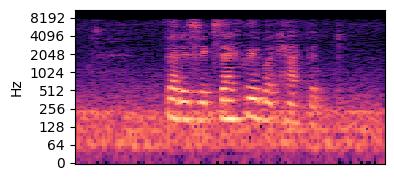

In [4]:
data, sampling_rate = librosa.load(np.array(data_path.Path[data_path.Emotions=="fear"])[300])

print(np.array(data_path.Path[data_path.Emotions=="fear"])[1425])
X = librosa.stft(data)
plt.figure(figsize=(4, 2))
Xdb = librosa.amplitude_to_db(abs(X),ref=np.max)
librosa.display.specshow(Xdb, sr=sampling_rate, y_axis="log")

In [5]:
# Switch this to true to regenerate the images of stock audios
REGENERATE_IMAGES = False
#generate the normal images
if(REGENERATE_IMAGES):
    total = 0
    from IPython.display import clear_output
    emotions=['happy', 'sad', 'angry', 'disgust', 'neutral', 'fear']
    headpath = os.path.join(os.getcwd(), "emotions_png")
    if not os.path.isdir(headpath):
        os.mkdir(headpath)
    for em in emotions:
        p2 = os.path.join(headpath, em) 
        if not os.path.isdir(p2):
            os.mkdir(p2)
    
        ct = 0
        processlist = np.array(data_path.Path[data_path.Emotions==em])
        for path in processlist:
            data, sampling_rate = librosa.load(path)
            if os.path.isfile(f'emotions_png/{em}/image_{ct}.png'):
                # This might be a point of issue if the array is random every time but hopefully that won't be an issue... right?
                clear_output(wait = True)
                ct += 1
                total += 1
                print(f"Percent Done: {(total/11378*100):.2f}%")
                continue
                # There is 100% a better way to do this but whatev
            create_spectrogram(data, sampling_rate, em)
            plt.savefig(f'emotions_png/{em}/image_{ct}.png', bbox_inches='tight', pad_inches=0) 
            plt.clf()
            plt.cla()
            plt.close()
            # Prevent memory leak
    
            ct += 1
            total += 1
            clear_output(wait = True)
            print(f"Percent Done: {(total/11378*100):.2f}%")

In [6]:
def noise(data):
    noise_amp = 0.01*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=1.5):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-8, high = 8)*1000)
    return np.roll(data, shift_range)

# data, sampling_rate = librosa.load(np.array(data_path.Path[data_path.Emotions=="fear"])[0])
# create_spectrogram((data), sampling_rate, "test")
# plt.show()
# create_spectrogram(noise(data), sampling_rate, "test")
# plt.show()
# create_spectrogram(stretch(data), sampling_rate, "test")
# plt.show()
# create_spectrogram(shift(data), sampling_rate, "test")
# plt.show()


'bruh'

In [7]:
# Switch this to true to adjust the audios and regenerate the images
REGENERATE_ALTIMAGES = False
import random

# Generate the changed images
if(REGENERATE_ALTIMAGES):
    total = 0
    from IPython.display import clear_output
    emotions=['happy', 'sad', 'angry', 'disgust', 'neutral', 'fear']
    headpath = os.path.join(os.getcwd(), "emotions_png")

    if not os.path.isdir(headpath):
        os.mkdir(headpath)
    
    for em in emotions:

        p2 = os.path.join(headpath, em) 
        if not os.path.isdir(p2):
            os.mkdir(p2)
    
        ct = 0
        processlist = np.array(data_path.Path[data_path.Emotions==em])
        for path in processlist:
            data, sampling_rate = librosa.load(path)
            if os.path.isfile(f'emotions_png/{em}/imageAlt_{ct}.png'):

                # This might be a point of issue if the array is random every time but hopefully that won't be an issue... right?
                clear_output(wait = True)
                ct += 1
                total += 1
                print(f"Percent Done: {(total/11378*100):.2f}%")
                continue

            rando = random.randint(1,3)

            if rando == 1:
                data = noise(data)
            elif rando == 2:
                data = stretch(data)
            elif rando == 3:
                data = shift(data)

            create_spectrogram(data, sampling_rate, em)
            plt.savefig(f'emotions_png/{em}/imageAlt_{ct}.png', bbox_inches='tight', pad_inches=0) 
            plt.clf()
            plt.cla()
            plt.close()
            # Close prevents memory leak, don't delete
    
            ct += 1
            total += 1
            clear_output(wait = True)
            print(f"Percent Done: {(total/11378*100):.2f}%")

In [8]:
# Compile all files into central dataset

import pathlib

img_width, img_height = 310, 154
batch_size = 16

data_dir = pathlib.Path("emotions_png").with_suffix('')
#split the data between training and validation
train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=3214,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=3214,
  image_size=(img_height, img_width),
  batch_size=batch_size)


import tensorflow as tf
print(train_ds.class_names)

AUTOTUNE = tf.data.AUTOTUNE
# Seems to aid accuracy? Look into later
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 22636 files belonging to 6 classes.
Using 18109 files for training.
Found 22636 files belonging to 6 classes.
Using 4527 files for validation.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']


In [9]:
def interpret_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(history.history['loss']))
    
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    return history.history['val_accuracy'][-1]

In [20]:
MAX_VAL_ACC = 0.5535674691200256
if os.path.isfile('model.h5'):
    temp = tf.keras.models.load_model('model.h5')
    loss, acc = temp.evaluate(train_ds)
    print("Imported model, accuracy: {:5.2f}%".format(100 * acc))
    MAX_VAL_ACC = max(MAX_VAL_ACC, acc)

1132/1132 [==============================] - 18s 16ms/step - loss: 0.0345 - accuracy: 0.9896
Imported model, accuracy: 98.96%


In [18]:
acc

283/283 [==============================] - 4s 13ms/step


array([[ -15.530678  ,  -21.996231  ,  -19.846693  ,  -13.841911  ,
          -7.1686015 ,   14.942384  ],
       [ -19.55595   ,  -14.045175  ,   -3.946439  ,   -7.426465  ,
         -11.183551  ,   14.086652  ],
       [  -1.5026529 ,  -14.308568  ,  -13.010218  ,  -15.157737  ,
          14.963611  ,  -24.007383  ],
       ...,
       [  -9.400418  ,   -0.19902168,  -10.118221  ,    5.598376  ,
           6.189872  ,   -5.2332773 ],
       [ -21.430046  ,    1.6760652 ,  -22.061716  ,  -14.444996  ,
          -3.369038  ,    9.643976  ],
       [  93.722435  ,  -51.106575  ,  -77.1579    ,  -82.59076   ,
        -105.07768   , -175.35446   ]], dtype=float32)

In [11]:
num_classes = 6
from keras import regularizers

In [24]:
from keras.callbacks import ModelCheckpoint

class SaveBestModel(ModelCheckpoint):

    def __init__(self, filepath, monitor='val_accuracy', save_best_only=True, **kwargs):
        super().__init__(filepath, monitor=monitor, save_best_only=save_best_only, **kwargs)
        self.best_accuracy = 0.0

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        
        if current_accuracy is not None and current_accuracy > self.best_accuracy:
            print("updated best!")
            self.best_accuracy = current_accuracy
            super().on_epoch_end(epoch, logs)


In [ ]:
# CNN model editing here>>>>>>>>>>>>

model = tf.keras.Sequential([
    
  #prevent overfitting
  #tf.keras.layers.Dropout(.2, input_shape=(img_height, img_width, 3)),

  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(4, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(8, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  
  # Dense + Regularizer
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),# kernel_regularizer=regularizers.l1_l2(l1=.0001/16, l2=.0001/16)),

  tf.keras.layers.Dense(num_classes)
])

###COMPILE AND FIT THE MODEL HERE, PRINT IF WE BEAT THE CURRENT MAX AND SAVE IT TO THE FILE
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

prevent_overfit = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min'
)
prevent_acc_drop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='min',
    patience=10,
    baseline=.5,
    start_from_epoch=5
)

save_best_callback = SaveBestModel(filepath='current_best.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=150,
  # callbacks=[prevent_overfit, prevent_acc_drop]
  callbacks=[save_best_callback]
)
print(f"Done in {len(history.history['loss'])} epochs with a final val_accuracy of {history.history['val_accuracy'][-1]}")

interpret_history(history)

if history.history['val_accuracy'][-1] > MAX_VAL_ACC:
    MAX_VAL_ACC = history.history['val_accuracy'][-1]
    model.save("model.h5")
    print("updated max to " + str(MAX_VAL_ACC))


Epoch 1/150
1132/1132 [==============================] - 51s 45ms/step - loss: 1.2074 - accuracy: 0.5154 - val_loss: 1.0390 - val_accuracy: 0.5938
Epoch 2/150
1132/1132 [==============================] - 50s 45ms/step - loss: 0.9743 - accuracy: 0.6163 - val_loss: 0.9233 - val_accuracy: 0.6494
Epoch 3/150
1132/1132 [==============================] - 50s 44ms/step - loss: 0.8555 - accuracy: 0.6689 - val_loss: 0.8865 - val_accuracy: 0.6572
Epoch 4/150
1132/1132 [==============================] - 50s 45ms/step - loss: 0.7418 - accuracy: 0.7168 - val_loss: 0.8949 - val_accuracy: 0.6660
Epoch 5/150
1132/1132 [==============================] - 50s 44ms/step - loss: 0.6254 - accuracy: 0.7665 - val_loss: 0.9235 - val_accuracy: 0.6751
Epoch 6/150
1132/1132 [==============================] - 50s 44ms/step - loss: 0.5178 - accuracy: 0.8047 - val_loss: 0.9676 - val_accuracy: 0.6793
Epoch 7/150
1132/1132 [==============================] - 50s 44ms/step - loss: 0.4234 - accuracy: 0.8453 - val_loss: 0

In [14]:
"""
# predicting on test data.
y_prediction = model.predict(val_ds)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)
# Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)
"""

"\n# predicting on test data.\ny_prediction = model.predict(val_ds)\ny_prediction = np.argmax (y_prediction, axis = 1)\ny_test=np.argmax(y_test, axis=1)\n#Create confusion matrix and normalizes it over predicted (columns)\nresult = confusion_matrix(y_test, y_prediction , normalize='pred')\nprint(result)\n"

In [ ]:
"""
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)
"""

# vim: set filetype=python:

In [1]:
history

history
